In [2]:
import pandas as pd

df = pd.read_csv('C:\\Users\\prane\\Documents\\Univ_of_Bristol\\mini-project\\simulated_transaction_2024.csv')
print(df.shape)

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Remove records with null values
#df_cleaned = df.dropna(subset=['Date', 'Account No', 'Amount'])
df_cleaned = df.dropna(subset=['Date', 'Account No'])

# Remove records where both Third Party Account No and Third Party Name are null
#df_cleaned = df_cleaned.dropna(subset=['Third Party Account No', 'Third Party Name'], how='all')

print("Shape of cleaned DataFrame:", df_cleaned.shape)

(230596, 7)
Shape of cleaned DataFrame: (230143, 7)


In [78]:
#Classification 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


df1 = pd.read_csv('C:\\Users\\prane\\Documents\\Univ_of_Bristol\\mini-project\\py-files\\classification_data.csv')

# One-hot encode categorical features (if any)
df1_encoded = pd.get_dummies(df1, columns=['Third Party Name'], prefix='', prefix_sep='')


#Training the model on mydata
# Splitting the dataset into features (X) and labels (y)
X = df1_encoded.drop('Category', axis=1)
y = df1_encoded['Category']

# Initialize and train the Random Forest model
model = RandomForestClassifier()
model.fit(X, y)


#Prediction Using orignal dataset
df2 = pd.read_csv('C:\\Users\\prane\\Documents\\Univ_of_Bristol\\mini-project\\simulated_transaction_2024.csv', parse_dates=['Date'], dayfirst=True)

df2['Date'] = pd.to_datetime(df2['Date'], format='%d/%m/%Y')
df2['month_year'] = df2['Date'].dt.to_period('M')
df2 = df2.dropna(subset=['Account No'])

df2_filtered = pd.DataFrame({
    'Account No' : df2['Account No'],
    'Third Party Name': df2['Third Party Name']
})

df2_encoded = pd.get_dummies(df2_filtered['Third Party Name'], columns=['Third Party Name'], prefix='', prefix_sep='')
df2_encoded_sorted = df2_encoded.reindex(columns=df1_encoded.iloc[:, 1:].columns, fill_value=0)

# Predict on the test set
predictions = model.predict(df2_encoded_sorted)
df2_filtered['Category'] = predictions
print("Classification is as follows")
print(df2_filtered.head())
print("-------------------------------------------------------")

# Create a mapping dictionary from 'Third Party Name' to 'Category'
label_mapping = df2_filtered.set_index('Third Party Name')['Category'].to_dict()

# Add the label column to the original DataFrame using map
df2['Category'] = df2['Third Party Name'].map(label_mapping)

# Display the updated DataFrame
print("After merging the classification to original df is as follows")
print(df2.head())
print(df2.shape)


Classification is as follows
    Account No    Third Party Name           Category
0  678330503.0  Westport Care Home  Health & Wellness
1  472213568.0    Barbiee Boutique  Fashion & Apparel
2  472213568.0                 NaN            Unknown
3  283027736.0                 NaN            Unknown
4  624500124.0            Fat Face  Fashion & Apparel
-------------------------------------------------------
After merging the classification to original df is as follows
        Date Timestamp   Account No  Balance  Amount  Third Party Account No  \
0 2023-01-01     00:00  678330503.0   2971.0  1584.0                     NaN   
1 2023-01-01     00:00  472213568.0   3792.0  1950.0                     NaN   
2 2023-01-01     00:00  472213568.0   3012.0  -780.0             283027736.0   
3 2023-01-01     00:00  283027736.0   1787.0   780.0             472213568.0   
4 2023-01-01     00:00  624500124.0   3226.0  1825.0                     NaN   

     Third Party Name month_year           Categ

In [ ]:
#Plots for customer behavior and data insights

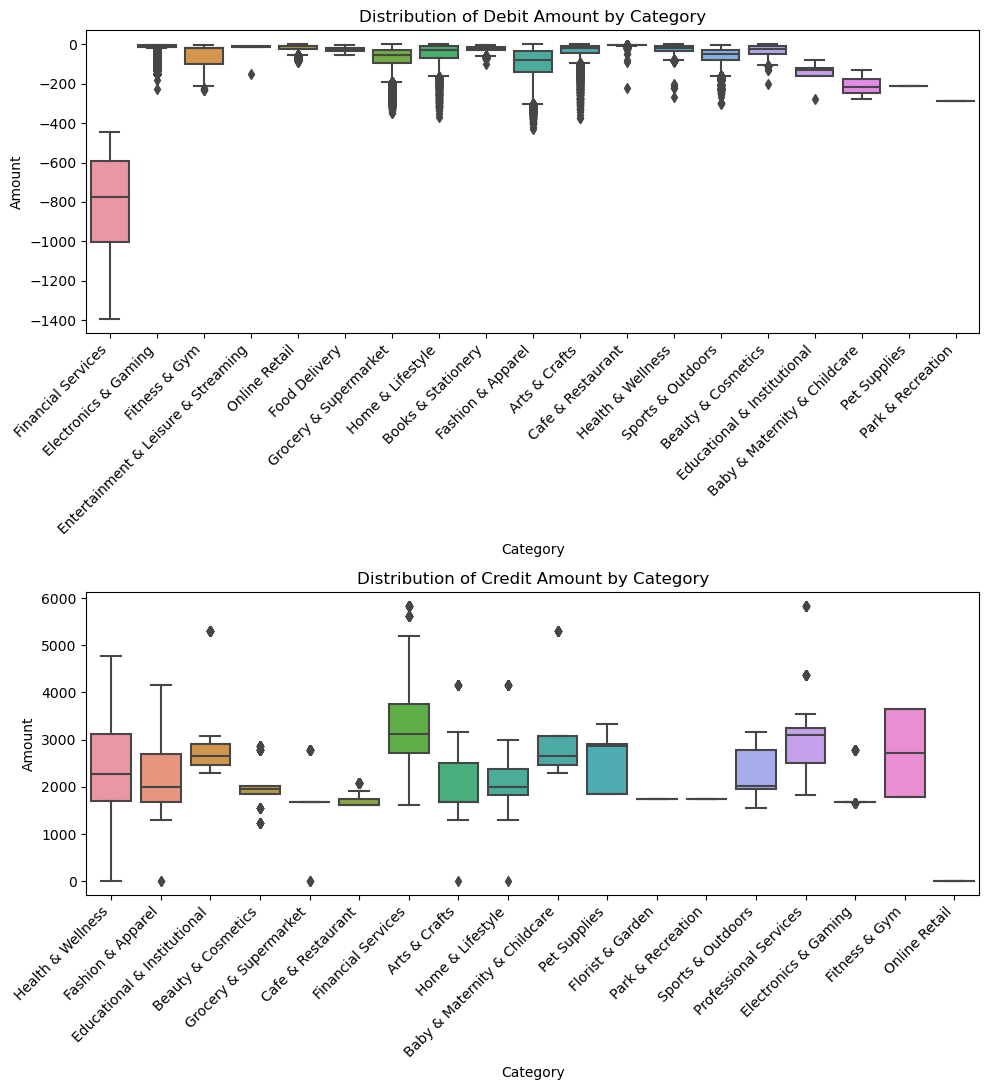

In [4]:
#1.1 Distribution of Amount in each category

import matplotlib.pyplot as plt
import seaborn as sns

df_neg_amount = df2[(df2['Amount'] < 0.0) & (df2['Category'] != 'Unknown') ]
df_pos_amount = df2[(df2['Amount'] >= 0.0) & (df2['Category'] != 'Unknown') ]

plt.figure(figsize=(10, 11))

# Box plot for predicted_label
plt.subplot(2, 1, 1)
sns.boxplot(x='Category', y='Amount', data=df_neg_amount)
plt.title('Distribution of Debit Amount by Category')
plt.xlabel('Category')
plt.ylabel('Amount')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
sns.boxplot(x='Category', y='Amount', data=df_pos_amount)
plt.title('Distribution of Credit Amount by Category')
plt.xlabel('Category')
plt.ylabel('Amount')
plt.xticks(rotation=45, ha='right')

# Violin plot for predicted_label
#plt.subplot(2, 1, 2)
#sns.violinplot(x='cluster', y='monopoly_money_amount', data=df2, inner='quartile', palette='viridis')
#plt.title('Distribution of Monopoly Amount by Cluster')
#plt.xlabel('Cluster')
#plt.ylabel('Monopoly Money Amount')

plt.tight_layout()
plt.show()


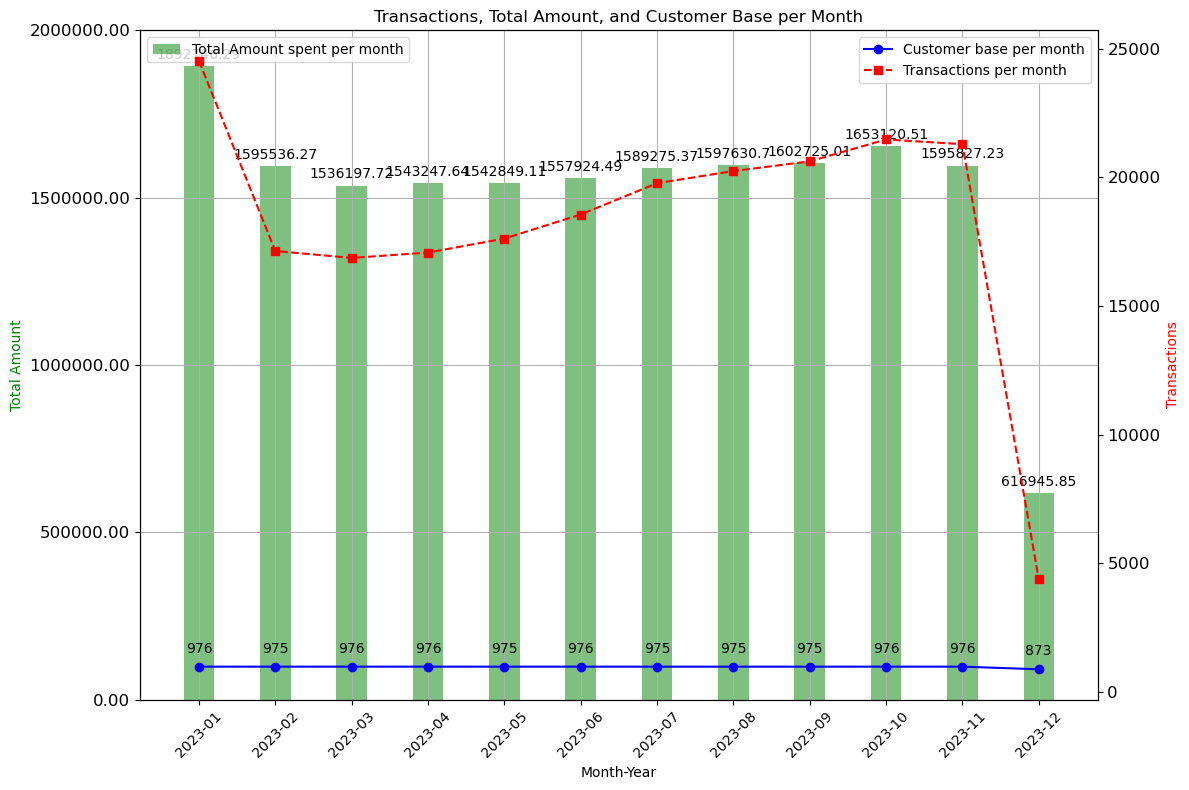

In [5]:
#Trend for popular month - Debit: Transaction freq, Total Amount spent, and Customer Base per Month

data = df2.copy()
#Filter to take only debit transactions
data = data[data['Amount'] < 0.0]

# Group by 'month_year' and 'Category', then count unique customers
#ignored null amounts
grouped_data = data.groupby(['month_year'])['Amount'].count().reset_index(name='Transactions per month')
grouped_data['Total Amount spent per month'] = data.groupby('month_year')['Amount'].sum().reset_index()['Amount'].abs()
grouped_data['Customer base per month'] = data.groupby('month_year')['Account No'].nunique().reset_index()['Account No']

# Ensure data types
grouped_data['month_year'] = grouped_data['month_year'].astype(str)
grouped_data['Transactions per month'] = pd.to_numeric(grouped_data['Transactions per month'], errors='coerce')
grouped_data['Total Amount spent per month'] = pd.to_numeric(grouped_data['Total Amount spent per month'], errors='coerce')
grouped_data['Customer base per month'] = pd.to_numeric(grouped_data['Customer base per month'], errors='coerce')

#print(grouped_data)

#Plotting
import matplotlib.pyplot as plt
import numpy as np

# Set up figure and dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot Total Amount spent per month as a bar plot on the left y-axis
bar_width = 0.4
bar_positions = np.arange(len(grouped_data['month_year']))
bars = ax1.bar(bar_positions, grouped_data['Total Amount spent per month'], color='green', alpha=0.5, width=bar_width, label='Total Amount spent per month')

# Set labels and title
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Total Amount', color='green')
plt.title('Transactions, Total Amount, and Customer Base per Month')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show grid for better visualization
ax1.grid(True)

# Display Customer base per month as line plot on the right y-axis
ax2 = ax1.twinx()
ax2.plot(grouped_data['month_year'], grouped_data['Customer base per month'], color='blue', marker='o', label='Customer base per month')

# Plot Transactions per month as a line plot on the right y-axis
ax2.plot(grouped_data['month_year'], grouped_data['Transactions per month'], color='red', marker='s', linestyle='--', label='Transactions per month')

# Set y-axis label for Customer base per month
ax2.set_ylabel('Customer base', color='blue')

# Set y-axis label for Transactions per month
ax2.set_ylabel('Transactions', color='red')

# Set y-axis ticks and labels for Total Amount spent per month
y_tick_interval = 500000  # Interval for y-axis ticks
y_tick_min = 0
y_tick_max = np.ceil(grouped_data['Total Amount spent per month'].max() / y_tick_interval) * y_tick_interval
y_ticks = np.arange(y_tick_min, y_tick_max + y_tick_interval, y_tick_interval)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(['{:.2f}'.format(value) for value in y_ticks])

# Set font size for y-axis tick labels
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

# Add legend for Total Amount spent per month and Customer base per month
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add labels at each data point of Customer base per month plot
for x, y in zip(grouped_data['month_year'], grouped_data['Customer base per month']):
    ax2.annotate('{}'.format(y), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    ax1.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
#Plots based on Category

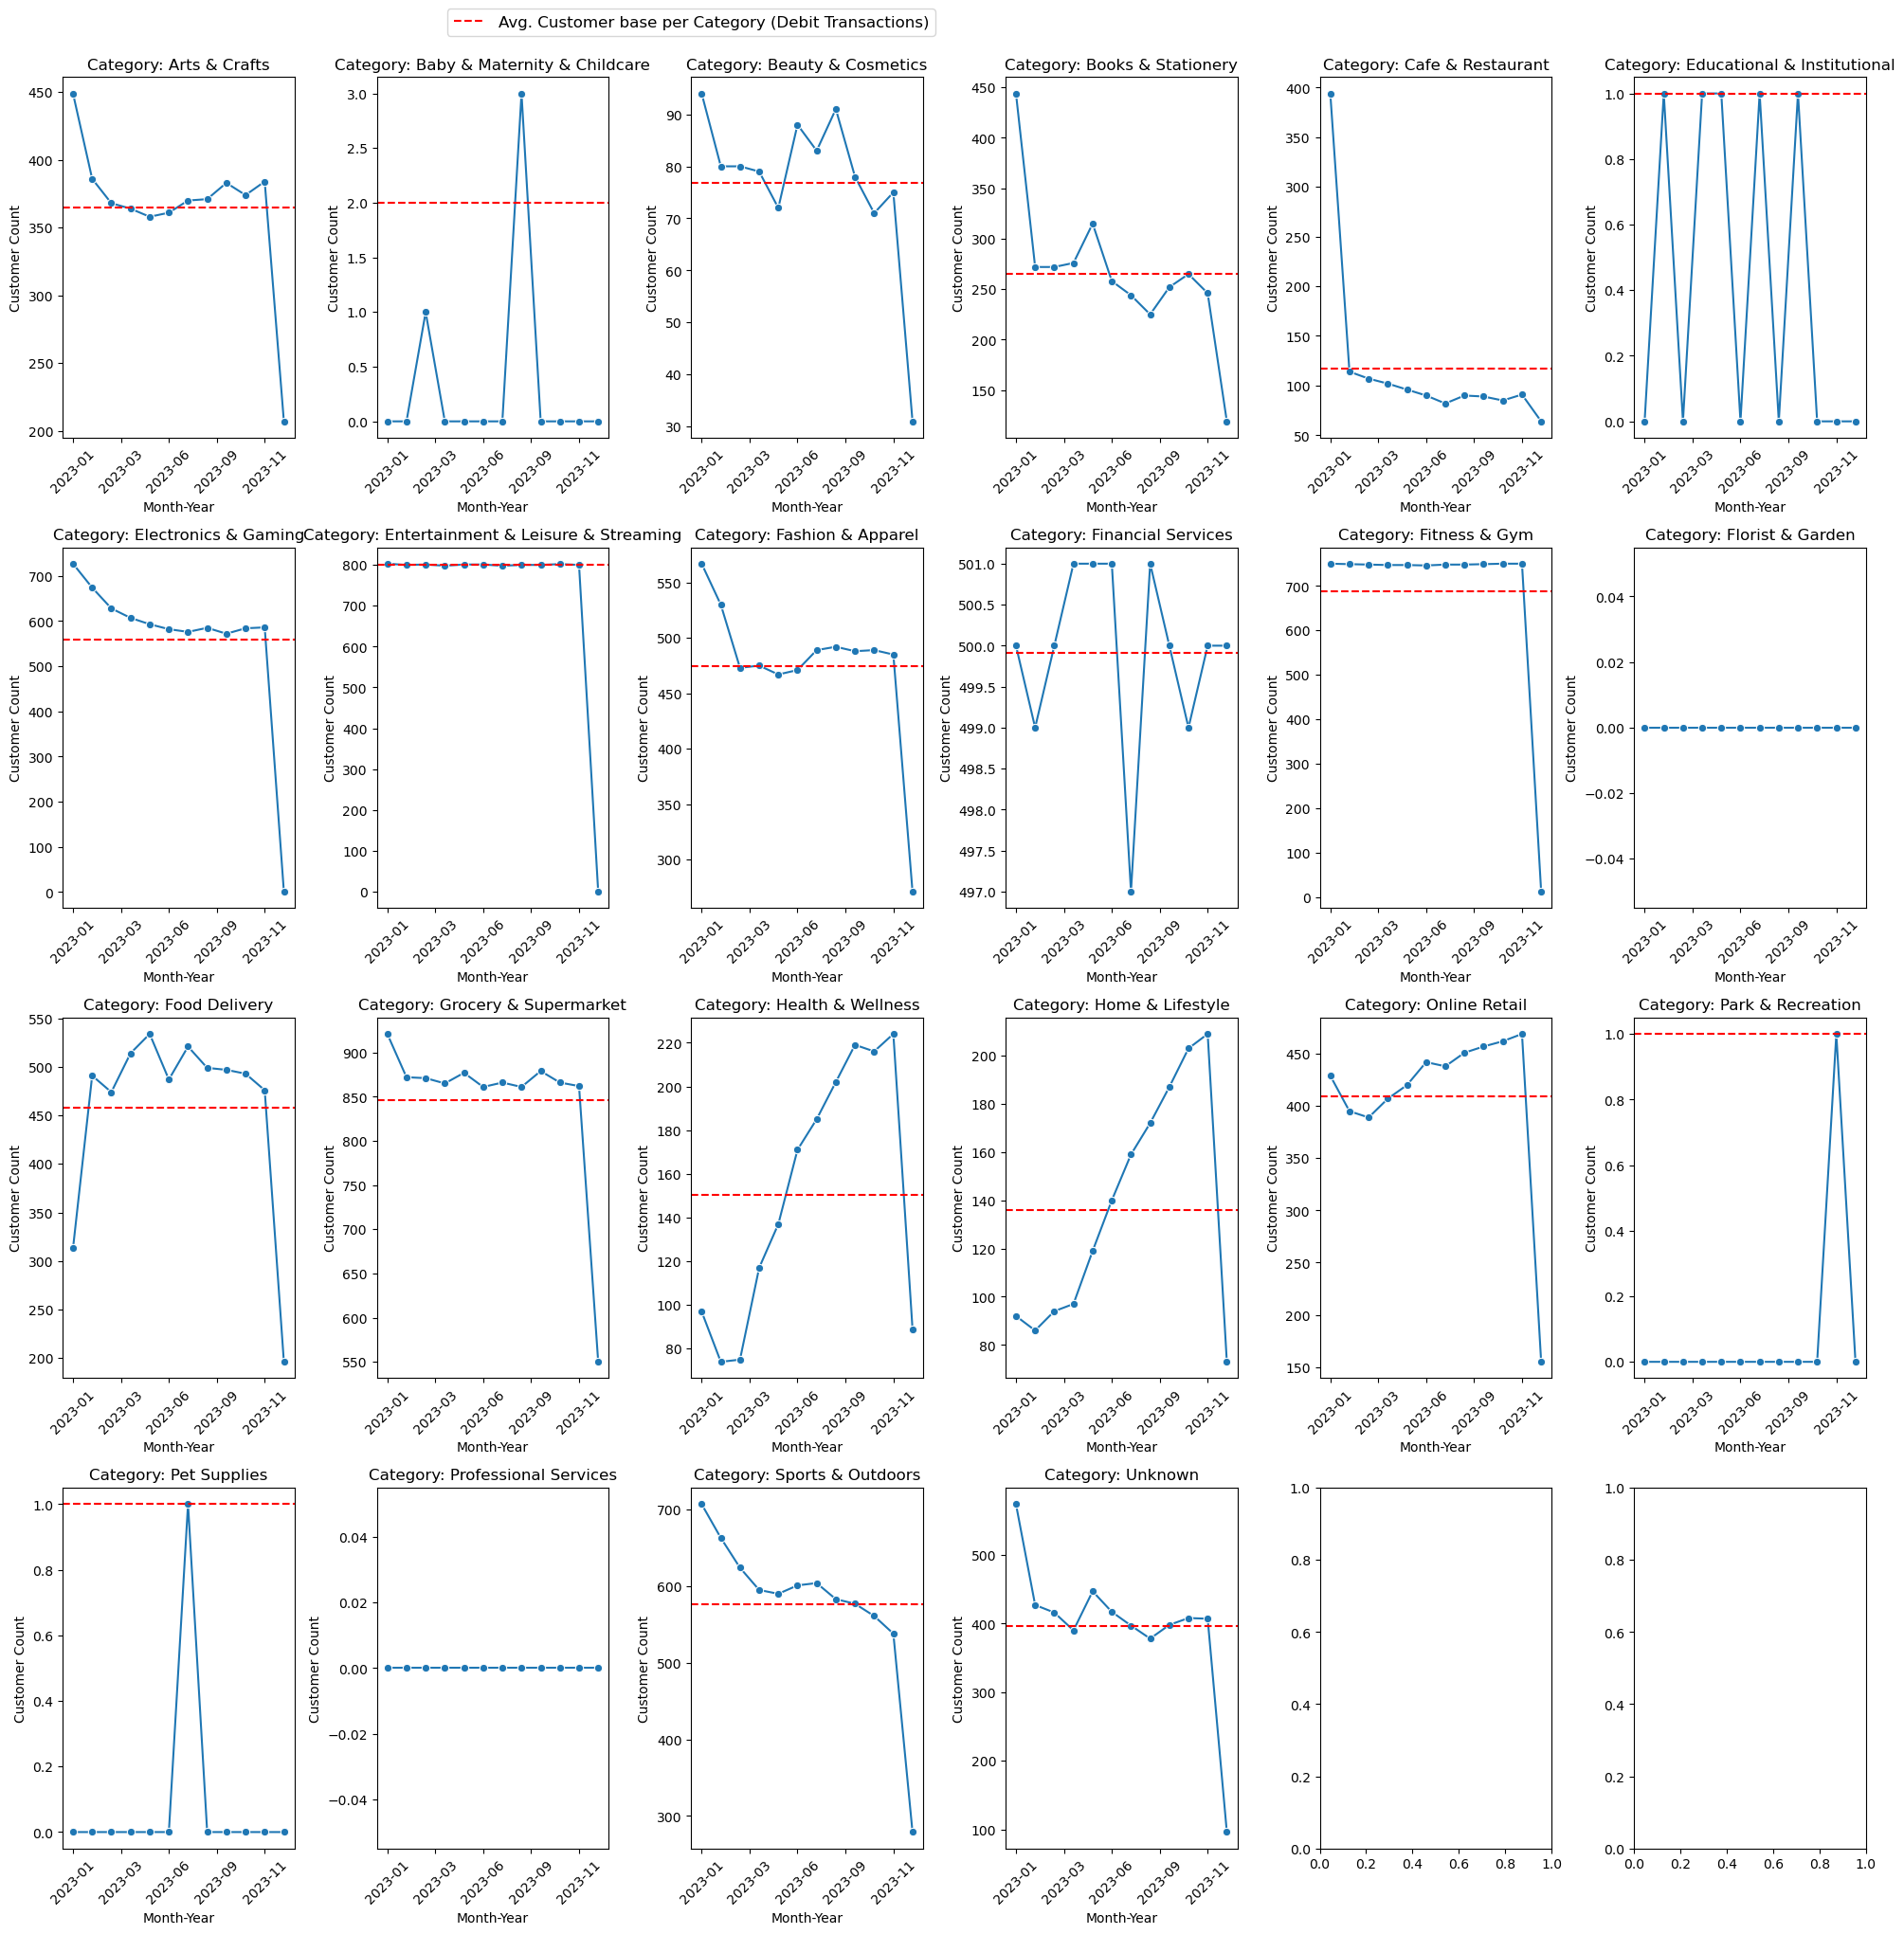

In [6]:
#Customer base for each category - Debit transactions

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

# Convert 'Category' to category for better plotting
df2['Category'] = df2['Category'].astype('category')

data = df2[df2['Amount'] < 0.0] #Debit transactions only

# Group by 'month_year' and 'Category', then count unique customers
grouped_data = data.groupby(['month_year', 'Category'])['Account No'].nunique().reset_index(name='Customer count per category')

# Ensure 'customer_count' is numeric
grouped_data['Customer count per category'] = pd.to_numeric(grouped_data['Customer count per category'], errors='coerce')

# Convert month_year column to strings for plotting
grouped_data['month_year'] = grouped_data['month_year'].astype(str)

# Filter out zero values
non_zero_data = grouped_data[grouped_data['Customer count per category'] != 0]
# Calculate the average customer count across all months combined
avg_customer_count = non_zero_data.groupby(['Category'])['Customer count per category'].mean().reset_index(name='Avg. Customer count per category')

#Plotting
# Set up the grid of plots
categories = grouped_data['Category'].unique()
num_categories = len(categories)
num_cols = 6
num_rows = int(np.ceil(num_categories / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows), sharex=False)

# Plot each category on a separate subplot
for i, category in enumerate(categories):
    row = i // num_cols
    col = i % num_cols
    data = grouped_data[grouped_data['Category'] == category]
    sns.lineplot(data=data, x='month_year', y='Customer count per category', ax=axes[row, col], marker='o')
    
    # Plot the average customer count for the category
    avg_count = avg_customer_count.loc[avg_customer_count['Category'] == category, 'Avg. Customer count per category'].values[0]
    axes[row, col].axhline(y=avg_count, color='red', linestyle='--', label=f'Avg. Customer count: {avg_count:.2f}')
    
    axes[row, col].set_title(f'Category: {category}')
    axes[row, col].set_xlabel('Month-Year')
    axes[row, col].set_ylabel('Customer Count')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].set_xticks(data['month_year'])
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(6))
    

# Add custom legend for the reference line
line = mlines.Line2D([], [], color='red', linestyle='--', label='Avg. Customer base per Category (Debit Transactions)')
fig.legend(handles=[line], loc='lower right', bbox_to_anchor=(0.5, 1), fontsize='large')

#plt.suptitle('Customer base per Category', fontsize=16)
plt.tight_layout()
plt.show()

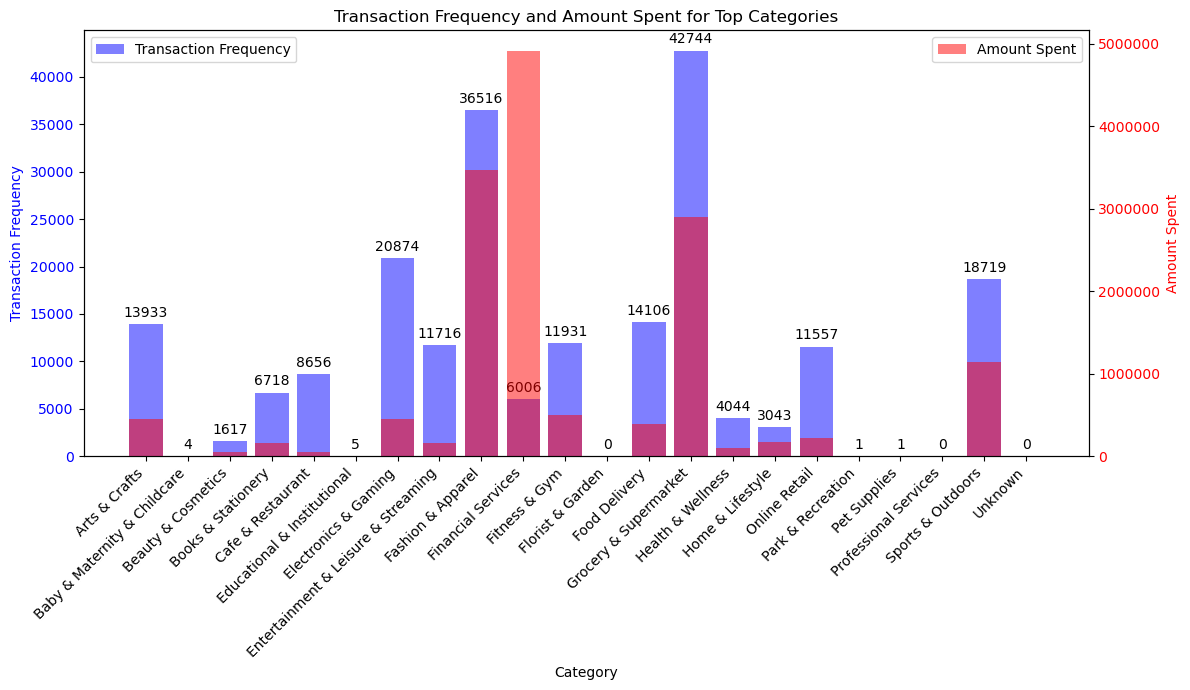

In [58]:
#Category wise Transaction frequency/counts and Amount spent - Debit transactions

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

data = df2[(df2['Amount'] < 0.0) & (df2['Category'] != 'Unknown' )] #Debit transactions only
df3 = data.copy()

# Transaction frequency/counts
#top_categories_count = df3.groupby('Category')['Amount'].count().nlargest(10).reset_index()
categories_count = df3.groupby('Category')['Amount'].count().reset_index()
categories_count.rename(columns={'Amount': 'Transaction frequency'}, inplace=True)

# Amount spent
#top_categories_amount = df3.groupby('Category')['Amount'].sum().abs().nlargest(10).reset_index()
categories_amount = df3.groupby('Category')['Amount'].sum().abs().reset_index()
categories_amount.rename(columns={'Amount': 'Amount spent'}, inplace=True)

#testing
#print("Top 10 categories with most transaction frequency/counts:")
#print(top_categories_count)
#print("\nTop 10 categories with most amount spent:")
#print(top_categories_amount)


# Merge the two DataFrames on 'Category' column
merged_df = pd.merge(categories_count, categories_amount, on='Category', how='outer')

# Define the categories and their corresponding indices
categories = merged_df['Category']
x = np.arange(len(categories))

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Transaction frequency on the first y-axis
bars1 = ax1.bar(x, merged_df['Transaction frequency'], color='b', alpha=0.5, label='Transaction Frequency')
ax1.set_ylabel('Transaction Frequency', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for Amount spent
ax2 = ax1.twinx()
bars2 = ax2.bar(x, merged_df['Amount spent'], color='r', alpha=0.5, label='Amount Spent')
ax2.set_ylabel('Amount Spent', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set labels, title, and legend
ax1.set_xlabel('Category')
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45, ha='right')
ax1.set_title('Transaction Frequency and Amount Spent for Top Categories')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set the formatter for the right y-axis to disable scientific notation
formatter = ScalarFormatter(useMathText=False)
ax2.yaxis.set_major_formatter(formatter)

# Format the tick labels on the right y-axis to display without scientific notation
ax2.ticklabel_format(style='plain', axis='y')

# Add labels above bars
for bars in [bars1]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate('{}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


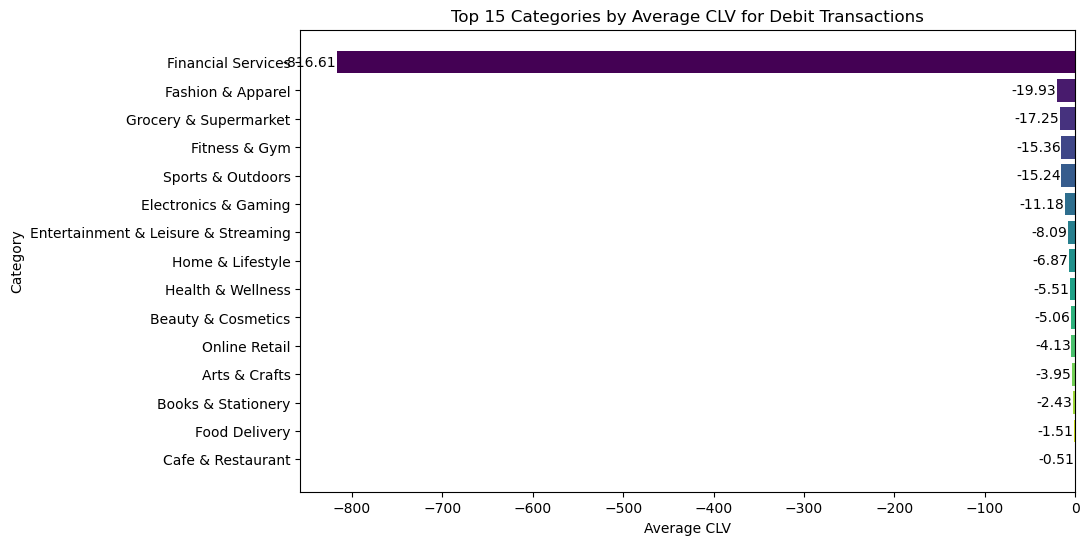

In [7]:
#Plot on avg CLV of all customers per category - Debit transactions

data3 = df2.copy()
data3 = data3[data3['Amount'] < 0.0] #Debit transactions only

# Calculate total revenue per customer
data3['total_revenue'] = data3.groupby(['Category', 'Account No'])['Amount'].transform('sum')

# Calculate total number of transactions per customer
data3['total_transactions'] = data3.groupby(['Category', 'Account No'])['Account No'].transform('count')

# Calculate average revenue per transaction per customer
data3['avg_revenue_per_transaction'] = data3['total_revenue'] / data3['total_transactions']

# Calculate average transaction frequency compared to cluster + classification 
data3['avg_transaction_frequency'] = data3.groupby(['Category'])['total_transactions'].transform(lambda x: x / x.max())

#Print the max no of transactions in each cluster + classification
#print(data3.groupby(['Category'])['total_transactions'].max())

# Calculate CLV
data3['clv'] = data3['avg_revenue_per_transaction'] * data3['avg_transaction_frequency']

#Keep only distinct account no's in each category
data3_filtered = data3.groupby('Category').apply(lambda x: x.drop_duplicates(subset=['Account No']))
data3_filtered = data3_filtered.reset_index(drop=True)

# Calculate average CLV for each category in a customer segment
average_clv_per_category = data3_filtered.groupby(['Category'])['clv'].mean().reset_index()

# Filter avg_customer_count to get categories with Avg. Customer count per category > 50 
#to avoid anomalous high clv categories having less customer count
filtered_categories = avg_customer_count[avg_customer_count['Avg. Customer count per category'] > 50]['Category']

# Filter average_clv_per_category based on the filtered categories
average_clv_per_category = average_clv_per_category[(average_clv_per_category['Category'].isin(filtered_categories)) & (average_clv_per_category['Category'] != 'Unknown')]

#print(data3_filtered[data3_filtered['Category'] == 'Financial Services'])
#print(average_clv_per_category)

import matplotlib.pyplot as plt
import numpy as np

# Sort categories by CLV
df_sorted = average_clv_per_category.sort_values(by='clv')

# Select top N categories (adjust N as needed)
N = average_clv_per_category['Category'].size
top_categories = df_sorted['Category'].tail(N)
top_clv_values = df_sorted['clv'].tail(N)

# Create a color gradient
colors = plt.cm.viridis(np.linspace(0, 1, N))

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_categories, top_clv_values, color=colors)
plt.xlabel('Average CLV')
plt.ylabel('Category')
plt.title(f'Top {N} Categories by Average CLV for Debit Transactions')
plt.gca().invert_yaxis()  # Invert y-axis to display categories from top to bottom

# Add text labels for each bar
for bar, value in zip(bars, top_clv_values):
    plt.text(value - 0.7, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', 
             va='center', ha='right')

plt.show()

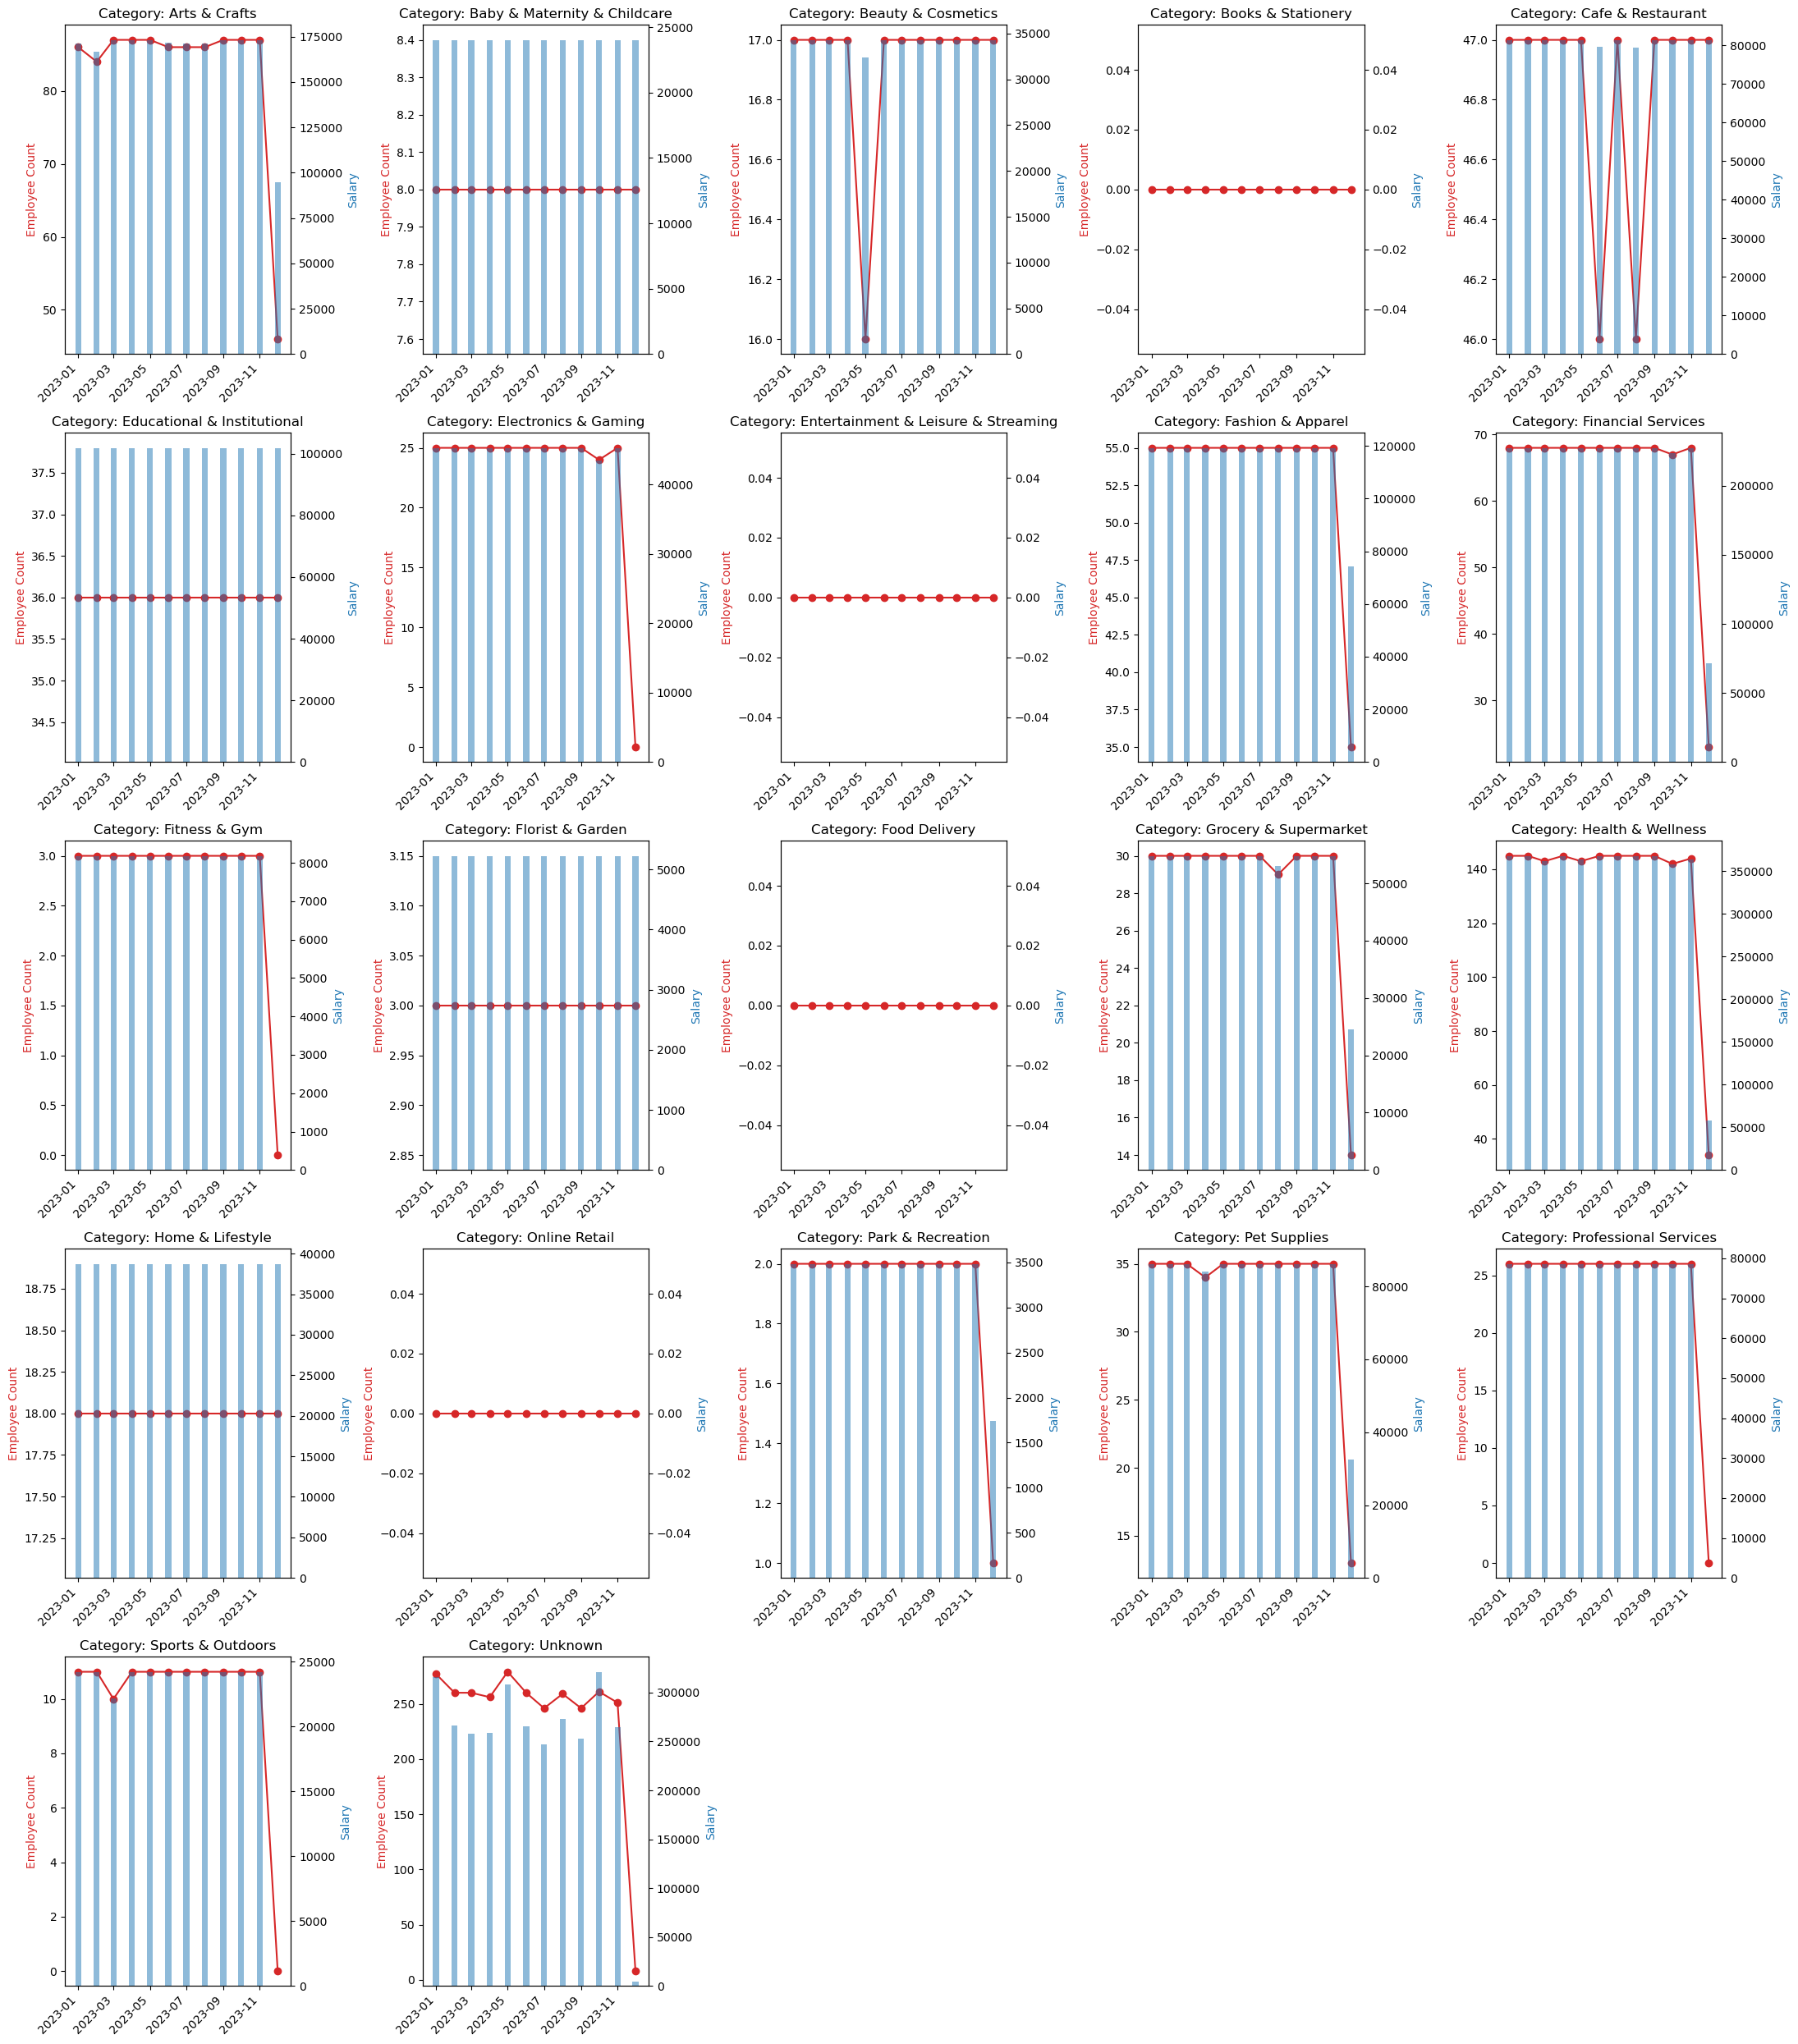

In [8]:
#Employee base & Salary for each category - Credit transactions

import matplotlib.pyplot as plt
import pandas as pd

data = df2[df2['Amount'] > 0.0] #Credit transactions only

# Group by 'month_year' and 'Category', then count unique customers
grouped_data = data.groupby(['month_year', 'Category']).agg({'Account No': 'nunique', 'Amount': 'sum'}).reset_index()

# Rename the columns for clarity
grouped_data.rename(columns={'Account No': 'Customer count per category', 'Amount': 'Salary per category'}, inplace=True)
#print(grouped_data[grouped_data['Category'] == 'Baby & Maternity & Childcare'])

# Ensure 'customer_count' is numeric
grouped_data['Customer count per category'] = pd.to_numeric(grouped_data['Customer count per category'], errors='coerce')
# Convert month_year column to strings for plotting
grouped_data['month_year'] = grouped_data['month_year'].astype(str)

# Convert 'Month' column to datetime
grouped_data['month_year'] = pd.to_datetime(grouped_data['month_year'])

# Plotting
# Get unique categories
categories = grouped_data['Category'].unique()

# Calculate the number of rows needed based on the number of categories
num_rows = (len(categories) + 4) // 5  # Ceiling division to ensure at least one row

# Create subplots for each category
fig, axes = plt.subplots(num_rows, 5, figsize=(22, 5*num_rows), sharex=False)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over each category
for i, category in enumerate(categories):
    # Filter data for the current category
    category_data = grouped_data[grouped_data['Category'] == category]
    
    # Plot employee count as a line plot
    color = 'tab:red'
    axes[i].plot(category_data['month_year'], category_data['Customer count per category'], color=color, marker='o', label='Employee Count')
    
    # Create a secondary y-axis for salary
    ax2 = axes[i].twinx()
    color = 'tab:blue'
    ax2.bar(category_data['month_year'], category_data['Salary per category'], color=color, alpha=0.5, label='Salary', width=10)
    
    # Add title and labels
    axes[i].set_title(f'Category: {category}')
    axes[i].set_ylabel('Employee Count', color='tab:red')
    ax2.set_ylabel('Salary', color='tab:blue')
    
    # Rotate x-axis labels for better readability
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Hide empty subplots if needed
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

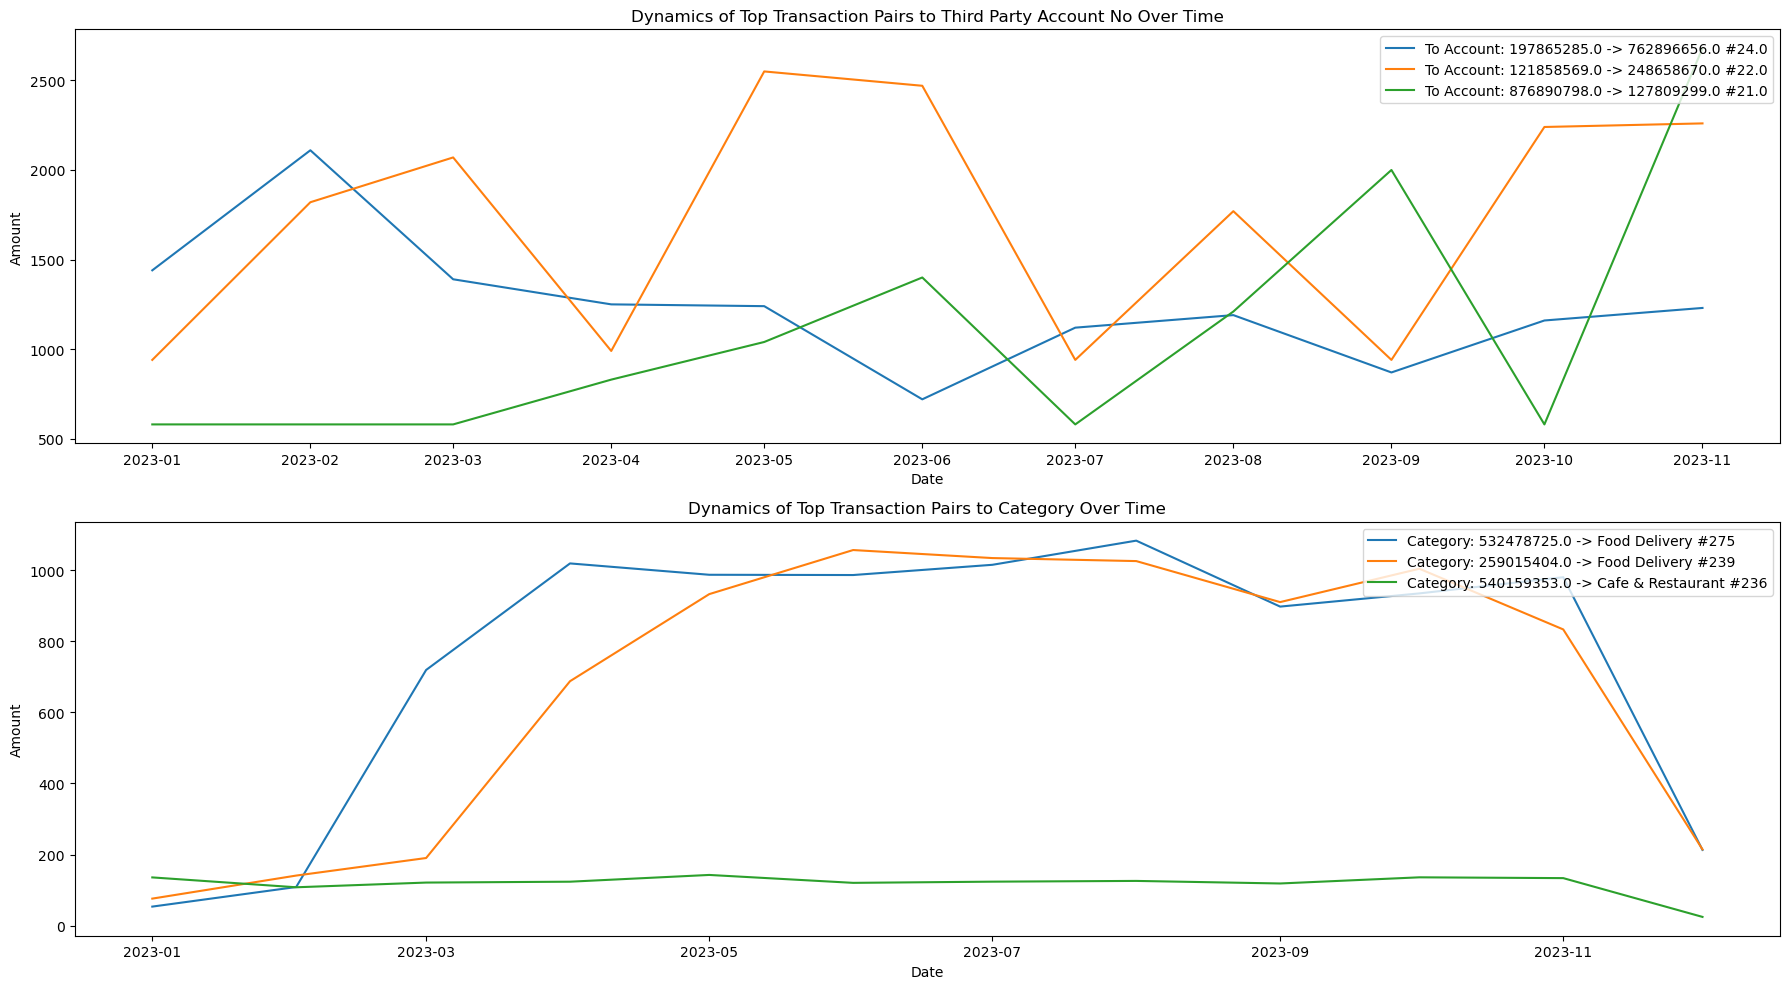

In [13]:
#2. Transaction Patterns : patterns of frequent debit transactions by Account No with
# Third party account No or Category 

# Filter rows with negative Amount, not null 'Account No' and 'Third Party Account No'/'Category'
df3 = df2[(df2['Amount'] < 0.0) & df2['Third Party Account No'].notnull() & df2['Account No'].notnull()][['Account No', 'Third Party Account No', 'Amount']]
df = df3.copy()
df_cat = df2[(df2['Amount'] < 0.0) & (df2['Category'] != 'Unknown') & (df2['Account No'].notnull())][['Account No', 'Category', 'Amount']]
df_category = df_cat.copy()

# Step 1: Calculate Relevant Metrics
df['Total Amount'] = df.groupby(['Account No', 'Third Party Account No'])['Amount'].transform('sum').abs()  # Absolute value of Amount
df['Transaction Count'] = df.groupby(['Account No', 'Third Party Account No'])['Amount'].transform('count')

df_category['Total Amount'] = df_category.groupby(['Account No', 'Category'])['Amount'].transform('sum').abs()  # Absolute value of Amount
df_category['Transaction Count'] = df_category.groupby(['Account No', 'Category'])['Amount'].transform('count')


# Drop duplicates based on 'Account No' and 'Third Party Account No'
df = df.drop_duplicates(subset=['Account No', 'Third Party Account No'])
df_category = df_category.drop_duplicates(subset=['Account No', 'Category'])

# Step 2: Rank Pairs
df.sort_values(by=['Transaction Count', 'Total Amount'], ascending=[False, False], inplace=True)  # Sort by Transaction Count and then Total Amount
df['Rank'] = df['Transaction Count'].rank(ascending=False, method='dense')  # Rank pairs based on Transaction Count

df_category.sort_values(by=['Transaction Count', 'Total Amount'], ascending=[False, False], inplace=True)  # Sort by Transaction Count and then Total Amount
df_category['Rank'] = df_category['Transaction Count'].rank(ascending=False, method='dense')  # Rank pairs based on Transaction Count

# Step 3: Filter Top 5 Pairs
top_pairs_to_account = df[df['Rank'] <=3] #top 3
top_pairs_predicted_label = df_category[df_category['Rank'] <=3] #top 3

# Step 4: Plot
plt.figure(figsize=(18, 10))

# Plot for 'Third Party Account No'
plt.subplot(2, 1, 1)
for index, row in top_pairs_to_account.iterrows():
    pair_data = df2[(df2['Account No'] == row['Account No']) & (df2['Third Party Account No'] == row['Third Party Account No'])]
    pair_data_monthly = pair_data.groupby(pair_data['Date'].dt.to_period("M")).agg({'Amount': 'sum'}).abs().reset_index()
    plt.plot(pair_data_monthly['Date'].dt.to_timestamp(), pair_data_monthly['Amount'], label=f"To Account: {row['Account No']} -> {row['Third Party Account No']} #{row['Transaction Count']}")
    
plt.title('Dynamics of Top Transaction Pairs to Third Party Account No Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend(loc='upper right')

# Plot for 'Third Party Account Name'
plt.subplot(2, 1, 2)
for index, row in top_pairs_predicted_label.iterrows():
    pair_data = df2[(df2['Account No'] == row['Account No']) & (df2['Category'] == row['Category'])]
    pair_data_monthly = pair_data.groupby(pair_data['Date'].dt.to_period("M")).agg({'Amount': 'sum'}).abs().reset_index()
    plt.plot(pair_data_monthly['Date'].dt.to_timestamp(), pair_data_monthly['Amount'], label=f"Category: {row['Account No']} -> {row['Category']} #{row['Transaction Count']}")
    
plt.title('Dynamics of Top Transaction Pairs to Category Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



In [11]:
#testing

df['Rank'] = df['Transaction Count'].rank(ascending=False, method='dense')  # Rank pairs based on Transaction Count
print(df[df['Transaction Count'] > 18])
print("----------------------")
#print(df_category['Rank'].unique()) # 1 to 183
print(df_category[df_category['Rank'] <=3])

        Account No  Third Party Account No  Amount  Total Amount  \
242    197865285.0             762896656.0  -720.0       13720.0   
20340  121858569.0             248658670.0  -940.0       18990.0   
20389  876890798.0             127809299.0  -580.0       12060.0   
151    833899961.0             668175891.0 -1110.0       15550.0   
224    454129843.0             593191200.0  -770.0       14160.0   
20692  169689461.0             413557825.0  -580.0        9480.0   
313    698955014.0             660561861.0 -1270.0       19120.0   
446    627622066.0             448004226.0  -770.0       14120.0   
199    291580432.0             812012103.0  -620.0        9520.0   

       Transaction Count  Rank  
242                   24   1.0  
20340                 22   2.0  
20389                 21   3.0  
151                   20   4.0  
224                   20   4.0  
20692                 20   4.0  
313                   19   5.0  
446                   19   5.0  
199                   

In [60]:
#Clustering

df_cluster = df2.copy()

# Group by 'Account No' and apply the transform function to count the number of transactions for each account
df_cluster['Transaction frequency'] = df_cluster.groupby('Account No')['Amount'].transform('count')
df_cluster = df_cluster.drop_duplicates(subset=['Account No'])
df_cluster = df_cluster[['Account No']].reset_index()

df_debit = df2[df2['Amount'] < 0.0].groupby('Account No')['Amount'].sum().reset_index()
df_credit = df2[df2['Amount'] > 0.0].groupby('Account No')['Amount'].sum().reset_index()
df_balance_monthly = df2[df2['Balance'].notna()].groupby(['Account No', 'month_year'])['Balance'].mean().reset_index()
df_balance =  df_balance_monthly.groupby(['Account No'])['Balance'].mean().reset_index()

#Top 3 categories with higest clv for each Account no.
data3_filtered['abs_clv'] = data3_filtered['clv'].abs()

 # Group by 'Account No' and find the top 3 categories with the highest absolute CLV
first_largest_category_per_account = data3_filtered[data3_filtered['Category'] != 'Unknown'].groupby('Account No').apply(lambda x: x.nlargest(1, 'abs_clv').iloc[-1]).reset_index(drop=True)
second_largest_category_per_account = data3_filtered[data3_filtered['Category'] != 'Unknown'].groupby('Account No').apply(lambda x: x.nlargest(2, 'abs_clv').iloc[-1]).reset_index(drop=True)
third_largest_category_per_account = data3_filtered[data3_filtered['Category'] != 'Unknown'].groupby('Account No').apply(lambda x: x.nlargest(3, 'abs_clv').iloc[-1]).reset_index(drop=True)

 # Drop the intermediate column 'abs_clv'
first_largest_category_per_account.drop(columns=['abs_clv'], inplace=True)
second_largest_category_per_account.drop(columns=['abs_clv'], inplace=True)
third_largest_category_per_account.drop(columns=['abs_clv'], inplace=True)

# Filter for dates for each quarter
start_date_q1 = pd.Timestamp(year=df2['Date'].iloc[0].year, month=1, day=1)
end_date_q1 = pd.Timestamp(year=df2['Date'].iloc[0].year, month=3, day=31)
start_date_q2 = pd.Timestamp(year=df2['Date'].iloc[0].year, month=4, day=1)
end_date_q2 = pd.Timestamp(year=df2['Date'].iloc[0].year, month=6, day=30)
start_date_q3 = pd.Timestamp(year=df2['Date'].iloc[0].year, month=7, day=1)
end_date_q3 = pd.Timestamp(year=df2['Date'].iloc[0].year, month=9, day=30)
start_date_q4 = pd.Timestamp(year=df2['Date'].iloc[0].year, month=10, day=1)
end_date_q4 = pd.Timestamp(year=df2['Date'].iloc[0].year, month=12, day=31)

#Yearly Net amount
df_net_amount_q1 = df2[(df2['Date'] >= start_date_q1) & (df2['Date'] <= end_date_q1)].groupby('Account No')['Amount'].sum().reset_index()
df_net_amount_q2 = df2[(df2['Date'] >= start_date_q2) & (df2['Date'] <= end_date_q2)].groupby('Account No')['Amount'].sum().reset_index()
df_net_amount_q3 = df2[(df2['Date'] >= start_date_q3) & (df2['Date'] <= end_date_q3)].groupby('Account No')['Amount'].sum().reset_index()
df_net_amount_q4 = df2[(df2['Date'] >= start_date_q4) & (df2['Date'] <= end_date_q4)].groupby('Account No')['Amount'].sum().reset_index()

# Create a mapping dictionary from 'Account No' to required agg feature
debit_label_mapping = df_debit.set_index('Account No')['Amount'].to_dict()
credit_label_mapping = df_credit.set_index('Account No')['Amount'].to_dict()
balance_label_mapping = df_balance.set_index('Account No')['Balance'].to_dict()
net_amount_q1_label_mapping = df_net_amount_q1.set_index('Account No')['Amount'].to_dict()
net_amount_q2_label_mapping = df_net_amount_q2.set_index('Account No')['Amount'].to_dict()
net_amount_q3_label_mapping = df_net_amount_q3.set_index('Account No')['Amount'].to_dict()
net_amount_q4_label_mapping = df_net_amount_q4.set_index('Account No')['Amount'].to_dict()
first_category_label_mapping = first_largest_category_per_account.set_index('Account No')['Category'].to_dict()
second_category_label_mapping = second_largest_category_per_account.set_index('Account No')['Category'].to_dict()
third_category_label_mapping = third_largest_category_per_account.set_index('Account No')['Category'].to_dict()

# Add the label column to the original DataFrame using map
df_cluster['Yearly Debit Amount'] = df_cluster['Account No'].map(debit_label_mapping)
df_cluster['Yearly Credit Amount'] = df_cluster['Account No'].map(credit_label_mapping)
df_cluster['Yearly Avg Balance'] = df_cluster['Account No'].map(balance_label_mapping)
df_cluster['Q1 Net Amount'] = df_cluster['Account No'].map(net_amount_q1_label_mapping)
df_cluster['Q2 Net Amount'] = df_cluster['Account No'].map(net_amount_q2_label_mapping)
df_cluster['Q3 Net Amount'] = df_cluster['Account No'].map(net_amount_q3_label_mapping)
df_cluster['Q4 Net Amount'] = df_cluster['Account No'].map(net_amount_q4_label_mapping)
df_cluster['Yearly Net Amount'] = df_cluster[['Yearly Debit Amount', 'Yearly Credit Amount']].sum(axis=1)
df_cluster['Top 1 category'] = df_cluster['Account No'].map(first_category_label_mapping)
df_cluster['Top 2 category'] = df_cluster['Account No'].map(second_category_label_mapping)
df_cluster['Top 3 category'] = df_cluster['Account No'].map(third_category_label_mapping)

#testing
#print(df_cluster[df_cluster['Account No'] == 678330503])
#print(df_cluster.columns)

#Clustering 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_cluster2 = df_cluster.copy()
df_cluster2['Yearly Credit Amount'].fillna(0, inplace=True)

# Define numerical and categorical features
numerical_features = ['Yearly Debit Amount', 'Yearly Credit Amount', 'Yearly Avg Balance', 'Yearly Net Amount']
categorical_features = ['Top 1 category', 'Top 2 category', 'Top 3 category']

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Fit pipeline on data
pipeline.fit(df_cluster2)

# Assign cluster
df_cluster2['Cluster'] = pipeline.named_steps['kmeans'].labels_

# Assign cluster labels
def assign_cluster_labels(cluster):
    if cluster == 0:
        return "High Spenders"
    elif cluster == 1:
        return "Regular Savers"
    elif cluster == 2:
        return "Potential Investors"

df_cluster2['Cluster Label'] = df_cluster2['Cluster'].apply(assign_cluster_labels)

# Analyze cluster characteristics (if needed)
cluster_characteristics = df_cluster2.groupby('Cluster Label').mean()

print(cluster_characteristics)
print("--------------------------------------------")
print()
print(df_cluster2[['Account No', 'Cluster Label']])

C:\Users\prane\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                           index    Account No  Yearly Debit Amount  \
Cluster Label                                                         
High Spenders        2193.162500  5.508146e+08         -7702.852562   
Potential Investors   899.046729  5.608650e+08        -24333.810561   
Regular Savers        717.504554  5.488549e+08        -24178.354681   

                     Yearly Credit Amount  Yearly Avg Balance  Q1 Net Amount  \
Cluster Label                                                                  
High Spenders                 5422.586250         -473.391302   -1496.029437   
Potential Investors          41217.850841        10870.965629    5880.580467   
Regular Savers               24920.986084         1699.179715     114.677049   

                     Q2 Net Amount  Q3 Net Amount  Q4 Net Amount  \
Cluster Label                                                      
High Spenders          -267.805156    -279.195531    -235.206375   
Potential Investors    4735.678505    3

C:\Users\prane\AppData\Local\Temp\ipykernel_11896\1973935895.py:125: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_characteristics = df_cluster2.groupby('Cluster Label').mean()


In [ ]:
#Customers with no salary account in bank

print(df_cluster2[df_cluster2['Yearly Credit Amount'].isnull()]) #100 records

In [16]:
print(df_cluster2[df_cluster2['Yearly Credit Amount'] == 0]['Yearly Avg Balance'].mean())

-1498.9708097806229


In [91]:
#Predicting Balance for month

print(df_cluster2.shape)

cluster_label_mapping = df_cluster2.set_index('Account No')['Cluster'].to_dict()
df_p['Cluster'] = df_cluster2['Account No'].map(cluster_label_mapping)

print(df_p.head())

(976, 15)
        Date Timestamp   Account No  Balance  Amount  Third Party Account No  \
0 2023-01-01     00:00  678330503.0   2971.0  1584.0                     NaN   
1 2023-01-01     00:00  472213568.0   3792.0  1950.0                     NaN   
2 2023-01-01     00:00  472213568.0   3012.0  -780.0             283027736.0   
3 2023-01-01     00:00  283027736.0   1787.0   780.0             472213568.0   
4 2023-01-01     00:00  624500124.0   3226.0  1825.0                     NaN   

     Third Party Name month_year           Category  Cluster  
0  Westport Care Home    2023-01  Health & Wellness      1.0  
1    Barbiee Boutique    2023-01  Fashion & Apparel      1.0  
2                 NaN    2023-01            Unknown      0.0  
3                 NaN    2023-01            Unknown      1.0  
4            Fat Face    2023-01  Fashion & Apparel      1.0  


In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pandas.api.types import CategoricalDtype

df_p = df2.copy()
df_p['month_year'] = df_p['month_year'].astype(str)

# Filter data for months 2023-01, 2023-02, and 2023-03
df_filtered = df_p[df_p['month_year'].isin(['2023-01', '2023-02', '2023-03'])]
df_filtered.dropna(subset=['Account No'], inplace=True)
df_filtered.dropna(subset=['Balance'], inplace=True)
df_filtered['Amount'].fillna(0, inplace=True)

#Add cluster info
cluster_label_mapping = df_cluster2.set_index('Account No')['Cluster'].to_dict()
df_p['Cluster'] = df_cluster2['Account No'].map(cluster_label_mapping)


# Split data into train and test sets based on unique 'Account No'
account_numbers = df_filtered['Account No'].unique()
train_accounts, test_accounts = train_test_split(account_numbers, test_size=0.2, random_state=42)

# Split the data into train and test sets
train_data = df_filtered[df_filtered['Account No'].isin(train_accounts)]
test_data = df_filtered[df_filtered['Account No'].isin(test_accounts)]

# Define numeric and categorical features
numeric_features = ['Account No', 'Amount']
categorical_features = ['Category']

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = RandomForestRegressor(random_state=42)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Separate features and target variable
X_train = train_data[['Account No', 'Amount', 'Category']]
y_train = train_data['Balance']
X_test = test_data[['Account No', 'Amount', 'Category']]
y_test = test_data['Balance']

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


C:\Users\prane\AppData\Local\Temp\ipykernel_11896\2034076016.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['Account No'], inplace=True)
C:\Users\prane\AppData\Local\Temp\ipykernel_11896\2034076016.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['Balance'], inplace=True)
C:\Users\prane\AppData\Local\Temp\ipykernel_11896\2034076016.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

Mean Squared Error: 4140858.2515197787


In [94]:
print(X_test)
print(y_test)
print(y_pred)

        Account No   Amount                             Category
32     370757362.0  1675.00                        Arts & Crafts
40     384497904.0   430.00                              Unknown
41     298000165.0  4167.00                     Home & Lifestyle
50     285428103.0  2648.10          Educational & Institutional
56     145387690.0  1675.00                    Cafe & Restaurant
...            ...      ...                                  ...
62346  572384506.0    -7.00                 Electronics & Gaming
62347  901037631.0  -100.00                        Fitness & Gym
62348  901037631.0    -7.99  Entertainment & Leisure & Streaming
62349  901037631.0   -15.99  Entertainment & Leisure & Streaming
62350  901037631.0   -18.99                        Fitness & Gym

[12502 rows x 3 columns]
32       3288.000000
40       1732.000000
41       6040.000000
50       3815.100000
56       2444.000000
            ...     
62346    8235.923947
62347    2118.231763
62348    2110.241763
62349